# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': -1,
        'fully_grown': True,    
        'dt_type': 'SDT', #'SDT', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': None, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'random_decision_tree_trained',# 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    
    'i_net': {
        'dense_layers': [2048, 1024, 256, 128],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.1, 0.1, 0.1, 0],
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.001,
        'loss': 'binary_crossentropy', #mse; soft_mse; binary_crossentropy; soft_binary_crossentropy; 'binary_accuracy'
        'metrics': ['soft_binary_crossentropy', 'binary_accuracy'],
        
        'epochs': 200, 
        'early_stopping': True,
        'batch_size': 512,

        'interpretation_dataset_size': 10000,
                
        'test_size': 50, #Float for fraction, Int for number 0
        
        'function_representation_type': 1, # 1=standard representation; 2=sparse representation with classification for variables
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
        'soft_labels': False,
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 50,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 500, 
        'per_network_optimization_dataset_size': 5000,

        'sklearn_dt_benchmark': False,
        'sdt_benchmark': False,
        
        'different_eval_data': True,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 10,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable


In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type == 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 3 and dt_type == 'SDT'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets10000_var10_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense2048-1024-256-128_drop0.1-0.1-0.1-0e200b512_adam
lNetSize5000_numLNets10000_var10_class2_random_decision_tree_trained_xMax1_xMin0_xDistuniform_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'        
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
       
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              config) for network_parameters_row in network_parameters.values)          
    del parallel
    
    base_model = generate_base_model(config)  
    
    #def initialize_network_wrapper(config, lambda_net, base_model):
    #    lambda_net.initialize_network(config, base_model)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_network_wrapper)(config, lambda_net, base_model) for lambda_net in lambda_nets)   
    #del parallel
    
    #def initialize_target_function_wrapper(config, lambda_net):
    #    lambda_net.initialize_target_function(config)
    
    #parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='sequential')
    #_ = parallel(delayed(initialize_target_function_wrapper)(config, lambda_net) for lambda_net in lambda_nets)   
    #del parallel
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    
    if False:
        lambda_net_dataset_train = load_lambda_nets(config_train, n_jobs=n_jobs)
        lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

        lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_train_with_valid = load_lambda_nets(config_train, n_jobs=n_jobs)
        lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

        _, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)   
        
        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    6.2s
[Parallel(n_jobs=10)]: Done 328 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 5066 tasks      | elapsed:    8.3s
[Parallel(n_jobs=10)]: Done 10000 out of 10000 | elapsed:   10.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done  81 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.4s finished


## Data Inspection

In [12]:
lambda_net_dataset_train.shape

(9000, 1632)

In [13]:
lambda_net_dataset_valid.shape

(1000, 1632)

In [14]:
lambda_net_dataset_test.shape

(50, 1632)

In [15]:
lambda_net_dataset_train.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
3289,3289.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.265,0.068,0.074,-1.210,-0.258,...,0.377,-0.085,0.914,2.160,0.332,-1.003,1.890,-1.857,0.405,0.892,-1.896,0.648,2.326,0.100,2.125,0.975,2.379,0.793,-1.097,1.761,-2.062,1.636,-0.133,-1.933,-0.113,-0.858,0.608,0.251,-0.106,-1.682,0.559,-0.075,1.178,-1.908,2.172,0.349,-0.127,1.106,-1.858,-1.315,-0.786,-2.053,0.107,0.133,-0.977,1.101,-0.928,-1.905,-0.774,0.600,-0.140,-0.122,-1.042,-0.943,1.733,0.800,1.575,-1.131,0.353,-0.372,-0.920,0.340,-1.411,-0.769,0.243,1.313,0.765,-1.850,0.359,0.266,-2.204,-1.047,-0.195,-0.759,-0.106,0.357,1.726,1.518,1.812,-0.972,-1.921,0.067,-0.284,1.370,0.364,0.982,-0.941,-3.500,1.430,0.063,1.715,0.133,0.295,0.219,1.243,-2.663,0.782,1.269,-0.767,0.128
7460,7460.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.029,0.006,0.003,0.030,0.032,...,-0.001,-1.376,1.094,0.155,0.463,-2.255,0.037,1.224,0.263,0.803,-2.208,0.092,0.865,0.119,1.773,0.394,1.656,0.991,-2.229,0.083,-1.241,0.242,-0.133,-1.671,-0.113,-0.939,0.304,-0.341,-2.318,-2.988,1.479,-2.333,1.445,-0.226,1.737,0.094,-2.576,-2.183,0.184,-0.421,-0.377,-1.723,1.914,0.168,0.341,0.468,-3.904,-4.383,-2.211,0.272,-1.926,-0.088,1.425,-3.939,0.962,0.144,-3.475,-2.428,0.154,-1.617,-1.648,0.439,-1.335,-4.798,-0.069,0.040,-1.303,-0.287,0.275,0.209,-0.443,-1.072,-2.674,-1.025,-0.106,0.253,0.977,0.083,2.026,-2.386,-2.082,0.067,-0.939,-2.029,0.633,-1.158,-2.280,-1.687,0.063,0.062,0.136,0.097,1.010,-0.149,-2.147,-3.543,0.090,-2.017,-3.006,0.367
6043,6043.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [16]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
7217,7217.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.045,0.087,-0.033,0.014,-0.009,...,1.295,-0.085,0.194,0.153,0.030,-0.458,0.926,0.803,1.727,1.080,-0.710,1.395,0.847,1.577,1.945,1.922,2.178,0.509,-0.461,2.254,-0.554,0.855,-0.133,-0.387,-0.113,-0.465,1.384,0.664,-0.432,-0.168,1.586,-1.323,1.375,-0.295,1.946,0.797,-1.105,1.057,1.514,-0.194,-0.091,-0.377,1.431,1.832,-0.847,-0.200,-0.383,1.121,2.301,0.745,-0.142,-0.196,-0.836,-0.901,0.068,0.523,0.703,-1.181,0.230,-0.126,-0.481,1.066,-0.377,-0.041,0.302,0.591,0.185,-0.184,0.650,0.406,-0.444,-0.651,-1.440,-0.083,-0.106,0.239,0.793,2.285,0.313,-0.532,-0.491,0.067,-0.166,-0.357,0.308,-0.130,-0.620,-0.700,0.049,2.190,0.137,0.269,0.502,-0.071,-0.373,-0.544,0.088,-0.328,0.247,-0.231
8291,8291.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.070,-0.058,-0.014,-0.094,-0.009,...,0.157,-0.079,0.035,0.399,0.087,-0.061,1.406,1.574,0.161,0.181,-0.338,0.041,0.323,0.273,0.374,0.973,1.526,0.124,-0.170,0.292,-1.409,0.224,-0.133,-0.915,-0.113,-0.093,1.246,0.069,-1.542,-1.026,1.310,-1.225,0.494,-0.716,2.089,0.640,-0.122,-1.032,0.213,-0.215,-0.092,-1.036,0.293,0.157,-0.990,-0.780,-0.972,-1.216,1.602,0.261,-1.142,1.179,-1.066,-1.231,1.057,1.286,-0.686,-1.110,1.604,-1.036,1.245,0.254,-1.042,-0.039,0.016,0.422,2.337,-0.978,0.059,0.015,-1.201,-0.291,-0.955,-0.835,-0.106,0.170,1.348,2.269,0.833,-0.165,-0.237,0.067,-1.267,1.362,0.216,-0.222,-1.282,-0.325,1.250,2.095,1.741,0.191,2.309,-0.873,-1.113,-0.417,1.262,-1.028,0.165,0.150
4607,4607.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [17]:
lambda_net_dataset_test.as_pandas(config).head()

,index,seed,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1,wb_0,wb_1,wb_2,wb_3,wb_4,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
29,29.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.104,-0.402,0.060,-0.621,0.089,...,-5.285,-0.085,2.270,0.164,-0.781,-0.080,0.073,3.246,2.227,-1.327,-5.393,-1.964,0.051,4.015,0.106,3.298,3.653,3.378,-0.201,0.102,-0.212,4.696,-0.133,-2.379,-0.113,-0.190,0.104,-0.151,-0.123,-4.104,3.321,-0.092,4.782,-5.651,0.209,-0.169,-0.133,2.070,0.006,-0.258,-0.107,-0.331,1.185,-0.482,-1.901,-0.247,-0.059,-3.194,0.000,2.931,-0.145,-3.058,-0.342,-2.870,-0.028,3.212,-4.198,-2.320,2.381,-0.122,-0.228,4.297,-0.331,-0.084,-0.241,-0.005,0.016,-0.049,0.097,-0.087,-3.442,-4.600,-0.203,-0.133,-0.106,-0.091,0.056,0.028,0.064,-0.193,-0.072,0.067,-0.167,-0.002,3.267,-0.354,-0.203,-3.282,1.932,0.076,0.144,-0.593,0.118,-0.084,-5.138,-3.673,-0.020,3.629,-0.141,-0.059
38,38.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.136,0.141,-0.521,0.029,0.026,...,0.096,-0.085,0.166,3.021,-0.212,-0.381,0.073,0.001,1.288,3.870,-0.342,2.101,0.261,0.187,2.525,0.152,0.133,0.062,-6.452,3.169,-0.206,0.119,-0.133,-0.140,-0.113,-0.211,2.524,0.441,-0.123,-0.261,0.462,-0.092,3.739,-0.411,4.464,2.280,-0.133,4.539,2.342,-0.000,-0.107,-5.545,0.502,2.706,-0.369,-0.141,-5.049,-4.374,0.000,0.572,-0.145,-5.662,-4.999,-3.488,2.699,-0.092,-6.121,-0.159,0.293,-0.043,3.306,-0.521,-6.021,-0.092,-0.185,0.047,-0.033,-0.222,2.714,-0.362,-4.060,-0.566,-0.203,-0.217,-0.106,0.129,8.815,0.108,0.971,-0.193,-0.072,0.067,-5.769,-0.006,0.057,-4.800,-0.203,-0.114,3.117,5.300,0.149,-0.010,0.033,-0.087,-0.178,-0.135,4.844,2.401,1.964,-0.053
79,79.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00

## Interpretation Network Training

In [18]:
#%load_ext tensorboard
#%tensorboard --logdir data/logging/ --port=8811

In [19]:
#%load_ext autoreload

In [20]:
#%autoreload 2
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      callback_names=['tensorboard'] #plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/200
18/18 [==============================] - 31s 815ms/step - loss: 0.6932 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6886 - binary_accuracy_inet_decision_function_fv_metric: 0.5442 - val_loss: 0.6642 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6724 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6140
Epoch 2/200
18/18 [==============================] - 8s 451ms/step - loss: 0.6574 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6669 - binary_accuracy_inet_decision_function_fv_metric: 0.6201 - val_loss: 0.6438 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6595 - val_binary_accuracy_inet_decision_function_fv_metric: 0.6343
Epoch 3/200
18/18 [==============================] - 9s 482ms/step - loss: 0.6356 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6532

<Figure size 432x288 with 0 Axes>

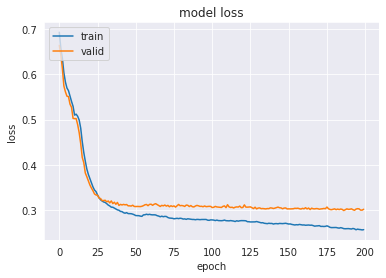

In [21]:
if nas:
    for trial in history: 
        print(trial.summary())
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

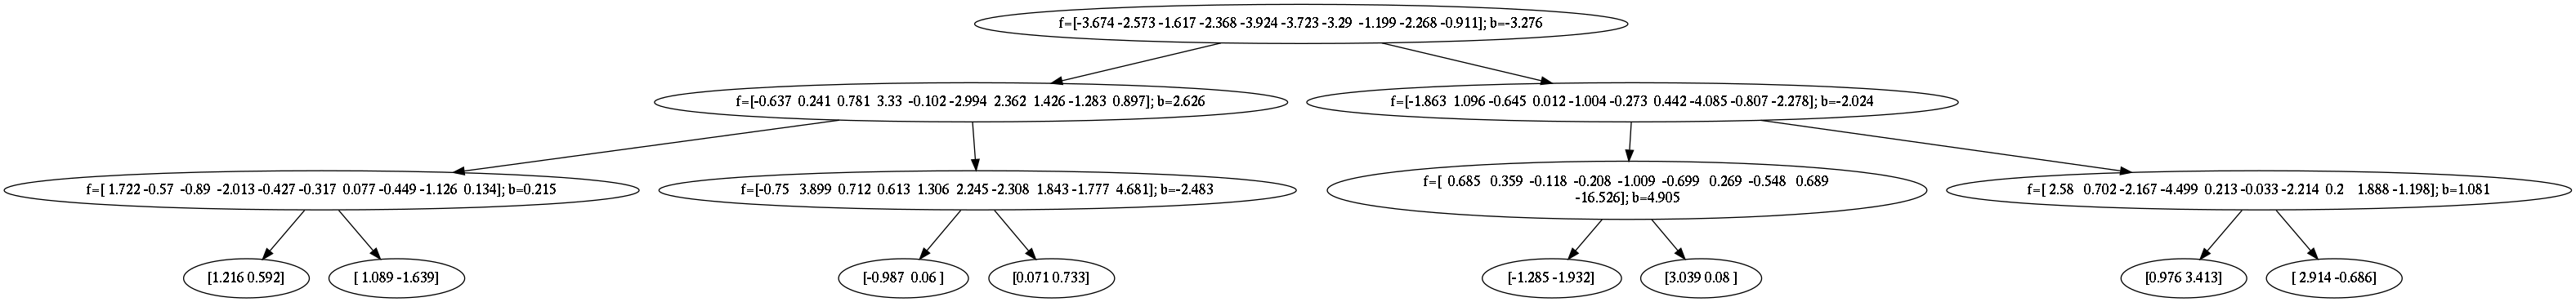

In [22]:
index = 3
network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
if (config['i_net']['convolution_layers'] != None or config['i_net']['lstm_layers'] != None or (config['i_net']['nas'] and config['i_net']['nas_type'] != 'SEQUENTIAL')) and config['i_net']['data_reshape_version'] is not None:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1537)]            0         
_________________________________________________________________
hidden1_2048 (Dense)         (None, 2048)              3149824   
_________________________________________________________________
activation1_relu (Activation (None, 2048)              0         
_________________________________________________________________
dropout1_0.1 (Dropout)       (None, 2048)              0         
_________________________________________________________________
hidden2_1024 (Dense)         (None, 1024)              2098176   
_________________________________________________________________
activation2_relu (Activation (None, 1024)              0         
_________________________________________________________________
dropout2_0.1 (Dropout)       (None, 1024)              0     

In [25]:
with tf.device('/CPU:0'):
    number = min(lambda_net_dataset_train.X_test_lambda_array.shape[0], 100)

    start_inet = time.time() 
    dt_inet_list = model.predict(np.array(lambda_net_dataset_train.network_parameters_array[:number]))
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    

    dt_inet_list = np.array(dt_inet_list)
    
    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=10, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_train.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_train.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict == None:
            inet_evaluation_result_dict = some_dict
        else:
            inet_evaluation_result_dict = mergeDict(inet_evaluation_result_dict, some_dict)

    inet_evaluation_result_dict['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean = {}

    for key_l1, values_l1 in inet_evaluation_result_dict.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean[key_l1][key_l2 + '_median'] = np.median(values_l2)

    inet_evaluation_result_dict_mean  
 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:

In [26]:
print('TRAIN DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)

TRAIN DATA RESULTS
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|               Metric              | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|  Soft Binary Crossentropy (Mean)  |              0.398               |          0.397           |        0.457         |
|     Binary Crossentropy (Mean)    |              0.125               |           0.13           |        0.262         |
|          Accuracy (Mean)          |              0.962               |           0.96           |        0.892         |
|          F1 Score (Mean)          |              0.958               |          0.956           |        0.872         |
|           Runtime (Mean)          |             222.456              |         222.456          |        0.002        

In [27]:
mean = np.mean(lambda_net_dataset_train.network_parameters_array, axis=0)
std = np.std(lambda_net_dataset_train.network_parameters_array, axis=0)


z_score_aggregate_list = []
for sample in lambda_net_dataset_train.network_parameters_array:
    z_score = (sample-mean)/std
    z_score_aggregate = np.sum(np.abs(z_score))
    z_score_aggregate_list.append(z_score_aggregate)

z_score_average_train = np.mean(z_score_aggregate_list)

initialization_array = shaped_network_parameters_to_array(generate_base_model(config).get_weights(), config)
distance_to_initialization_aggregate_list = []
for sample in lambda_net_dataset_train.network_parameters_array:
    distance_to_initialization = sample - initialization_array
    distance_to_initialization_aggregate = np.sum(np.abs(distance_to_initialization))
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)

distance_to_initialization_average_train = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_list = []
distance_to_sample_min_list = []
for sample1 in tqdm(lambda_net_dataset_train.network_parameters_array[:100]):
    distance_to_sample_aggregate_list = []
    for sample2 in lambda_net_dataset_train.network_parameters_array:
        distance_to_sample = sample1 - sample2
        distance_to_sample_aggregate = np.sum(np.abs(distance_to_sample))
        distance_to_sample_aggregate_list.append(distance_to_sample_aggregate)

    distance_to_sample_average = np.mean(distance_to_sample_aggregate_list)
    distance_to_sample_min = np.min(distance_to_sample_aggregate_list)
    
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)
    
distance_to_sample_average_average_train = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average_train = np.mean(distance_to_sample_min_list)
    
print('Average Z-Score (Sample to Train Data):\t\t', np.round(z_score_average_train, 3))
print('Average Distance to Initialization:\t\t', np.round(distance_to_initialization_average_train, 3))   
    
print('Average Mean Distance to Train Data:\t\t', np.round(distance_to_sample_average_average_train, 3))   
print('Average Distance to closest Train Data Sample:\t', np.round(distance_to_sample_min_average_train, 3))   



  0%|          | 0/100 [00:00<?, ?it/s]

Average Z-Score (Sample to Train Data):		 nan
Average Distance to Initialization:		 304.694
Average Mean Distance to Train Data:		 426.834
Average Distance to closest Train Data Sample:	 0.0


In [28]:
with tf.device('/CPU:0'):
    number = min(lambda_net_dataset_valid.X_test_lambda_array.shape[0], 100)

    start_inet = time.time() 
    dt_inet_list = model.predict(np.array(lambda_net_dataset_valid.network_parameters_array[:number]))
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    

    dt_inet_list = np.array(dt_inet_list)

    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_valid.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_valid.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict == None:
            inet_evaluation_result_dict = some_dict
        else:
            inet_evaluation_result_dict = mergeDict(inet_evaluation_result_dict, some_dict)

    inet_evaluation_result_dict['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean = {}

    for key_l1, values_l1 in inet_evaluation_result_dict.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean[key_l1][key_l2 + '_median'] = np.median(values_l2)

    inet_evaluation_result_dict_mean  
 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 33.1min finished


In [29]:
print('VALID DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)

VALID DATA RESULTS
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|               Metric              | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|  Soft Binary Crossentropy (Mean)  |              0.387               |          0.389           |        0.465         |
|     Binary Crossentropy (Mean)    |               0.11               |          0.115           |        0.304         |
|          Accuracy (Mean)          |              0.968               |          0.966           |        0.875         |
|          F1 Score (Mean)          |              0.965               |          0.963           |        0.869         |
|           Runtime (Mean)          |             192.861              |         192.861          |        0.003        

In [30]:
mean = np.mean(lambda_net_dataset_train.network_parameters_array, axis=0)
std = np.std(lambda_net_dataset_train.network_parameters_array, axis=0)

z_score_aggregate_list = []
for sample in lambda_net_dataset_valid.network_parameters_array:
    z_score = (sample-mean)/std
    z_score_aggregate = np.sum(np.abs(z_score))
    z_score_aggregate_list.append(z_score_aggregate)

z_score_average = np.mean(z_score_aggregate_list)

initialization_array = shaped_network_parameters_to_array(generate_base_model(config).get_weights(), config)
distance_to_initialization_aggregate_list = []
for sample in lambda_net_dataset_valid.network_parameters_array:
    distance_to_initialization = sample - initialization_array
    distance_to_initialization_aggregate = np.sum(np.abs(distance_to_initialization))
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)

distance_to_initialization_average = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_list = []
distance_to_sample_min_list = []
for sample1 in tqdm(lambda_net_dataset_valid.network_parameters_array[:100]):
    distance_to_sample_aggregate_list = []
    for sample2 in lambda_net_dataset_train.network_parameters_array:
        distance_to_sample = sample1 - sample2
        distance_to_sample_aggregate = np.sum(np.abs(distance_to_sample))
        distance_to_sample_aggregate_list.append(distance_to_sample_aggregate)

    distance_to_sample_average = np.mean(distance_to_sample_aggregate_list)
    distance_to_sample_min = np.min(distance_to_sample_aggregate_list)
    
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)
    
distance_to_sample_average_average = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average = np.mean(distance_to_sample_min_list)
    
print('Average Z-Score (Sample to Train Data):\t\t', np.round(z_score_average, 3), '\t', '(' + str(np.round(z_score_average_train, 3)) + ' for Train)')
print('Average Distance to Initialization:\t\t', np.round(distance_to_initialization_average, 3), '\t', '(' + str(np.round(distance_to_initialization_average_train, 3)) + ' for Train)')    

print('Average Mean Distance to Train Data:\t\t', np.round(distance_to_sample_average_average, 3), '\t', '(' + str(np.round(distance_to_sample_average_average_train, 3)) + ' for Train)')   
print('Average Distance to closest Train Data Sample:\t', np.round(distance_to_sample_min_average, 3), '\t', '(' + str(np.round(distance_to_sample_min_average_train, 3)) + ' for Train)')   



  0%|          | 0/100 [00:00<?, ?it/s]

Average Z-Score (Sample to Train Data):		 nan 	 (nan for Train)
Average Distance to Initialization:		 302.966 	 (304.694 for Train)
Average Mean Distance to Train Data:		 432.495 	 (426.834 for Train)
Average Distance to closest Train Data Sample:	 224.974 	 (0.0 for Train)


In [31]:
with tf.device('/CPU:0'):
    number = lambda_net_dataset_test.X_test_lambda_array.shape[0]#10

    start_inet = time.time() 
    dt_inet_list = model.predict(np.array(lambda_net_dataset_test.network_parameters_array[:number]))
    end_inet = time.time()     
    inet_runtime = (end_inet - start_inet)    

    dt_inet_list = np.array(dt_inet_list)

    parallel_inet_evaluation = Parallel(n_jobs=n_jobs, verbose=1, backend='loky') #loky #sequential multiprocessing
    inet_evaluation_results_with_dt = parallel_inet_evaluation(delayed(evaluate_interpretation_net_prediction_single_sample)(lambda_net_parameters, 
                                                                                                                   dt_inet,
                                                                                                                   X_test_lambda, 
                                                                                                                   #y_test_lambda,
                                                                                                                   config) for lambda_net_parameters, 
                                                                                                                               dt_inet, 
                                                                                                                               X_test_lambda in zip(lambda_net_dataset_test.network_parameters_array[:number], 
                                                                                                                                                    dt_inet_list, 
                                                                                                                                                    lambda_net_dataset_test.X_test_lambda_array[:number]))      

    del parallel_inet_evaluation

    inet_evaluation_results = [entry[0] for entry in inet_evaluation_results_with_dt]
    dt_distilled_list = [entry[1] for entry in inet_evaluation_results_with_dt]


    inet_evaluation_result_dict = None
    for some_dict in inet_evaluation_results:
        if inet_evaluation_result_dict == None:
            inet_evaluation_result_dict = some_dict
        else:
            inet_evaluation_result_dict = mergeDict(inet_evaluation_result_dict, some_dict)

    inet_evaluation_result_dict['inet_scores']['runtime'] = [inet_runtime/number for _ in range(number)]


    inet_evaluation_result_dict_mean = {}

    for key_l1, values_l1 in inet_evaluation_result_dict.items():
        if key_l1 != 'function_values':
            if isinstance(values_l1, dict):
                inet_evaluation_result_dict_mean[key_l1] = {}
                for key_l2, values_l2 in values_l1.items():
                    inet_evaluation_result_dict_mean[key_l1][key_l2] = np.mean(values_l2)
                    inet_evaluation_result_dict_mean[key_l1][key_l2 + '_median'] = np.median(values_l2)

    inet_evaluation_result_dict_mean  
 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 16.4min finished


In [32]:
print('TEST DATA RESULTS')

tab = PrettyTable()
tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
tab.add_rows(
    [
        ['Soft Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['soft_binary_crossentropy'], 3)],
        ['Binary Crossentropy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy'], 3)],
        ['Accuracy (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy'], 3)],
        ['F1 Score (Mean)', np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_data_random'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score'], 3)],
        ['Runtime (Mean)',  np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['runtime'], 3)],
        ['Soft Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['soft_binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['soft_binary_crossentropy_median'], 3)],
        ['Binary Crossentropy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy_median'], 3)],
        ['Accuracy (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['accuracy_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['accuracy_median'], 3)],
        ['F1 Score (Median)', np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_data_random_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['f1_score_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['f1_score_median'], 3)],
        ['Runtime (Median)',  np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean['dt_scores']['runtime_median'], 3), np.round(inet_evaluation_result_dict_mean['inet_scores']['runtime_median'], 3)],
    ]    
)
print(tab)

TEST DATA RESULTS
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|               Metric              | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+-----------------------------------+----------------------------------+--------------------------+----------------------+
|  Soft Binary Crossentropy (Mean)  |               0.42               |          0.421           |        0.607         |
|     Binary Crossentropy (Mean)    |              0.149               |          0.154           |        0.564         |
|          Accuracy (Mean)          |              0.949               |          0.947           |        0.695         |
|          F1 Score (Mean)          |               0.92               |          0.919           |        0.683         |
|           Runtime (Mean)          |             190.236              |         190.236          |        0.006         

In [33]:
mean = np.mean(lambda_net_dataset_train.network_parameters_array, axis=0)
std = np.std(lambda_net_dataset_train.network_parameters_array, axis=0)

z_score_aggregate_list = []
for sample in lambda_net_dataset_test.network_parameters_array:
    z_score = (sample-mean)/std
    z_score_aggregate = np.sum(np.abs(z_score))
    z_score_aggregate_list.append(z_score_aggregate)

z_score_average = np.mean(z_score_aggregate_list)

initialization_array = shaped_network_parameters_to_array(generate_base_model(config).get_weights(), config)
distance_to_initialization_aggregate_list = []
for sample in lambda_net_dataset_test.network_parameters_array:
    distance_to_initialization = sample - initialization_array
    distance_to_initialization_aggregate = np.sum(np.abs(distance_to_initialization))
    distance_to_initialization_aggregate_list.append(distance_to_initialization_aggregate)

distance_to_initialization_average = np.mean(distance_to_initialization_aggregate_list)

distance_to_sample_average_list = []
distance_to_sample_min_list = []
for sample1 in tqdm(lambda_net_dataset_test.network_parameters_array[:100]):
    distance_to_sample_aggregate_list = []
    for sample2 in lambda_net_dataset_train.network_parameters_array:
        distance_to_sample = sample1 - sample2
        distance_to_sample_aggregate = np.sum(np.abs(distance_to_sample))
        distance_to_sample_aggregate_list.append(distance_to_sample_aggregate)

    distance_to_sample_average = np.mean(distance_to_sample_aggregate_list)
    distance_to_sample_min = np.min(distance_to_sample_aggregate_list)
    
    distance_to_sample_average_list.append(distance_to_sample_average)
    distance_to_sample_min_list.append(distance_to_sample_min)
    
distance_to_sample_average_average = np.mean(distance_to_sample_average_list)
distance_to_sample_min_average = np.mean(distance_to_sample_min_list)
    
print('Average Z-Score (Sample to Train Data):\t\t', np.round(z_score_average, 3), '\t', '(' + str(np.round(z_score_average_train, 3)) + ' for Train)')
print('Average Distance to Initialization:\t\t', np.round(distance_to_initialization_average, 3), '\t', '(' + str(np.round(distance_to_initialization_average_train, 3)) + ' for Train)')   
    
print('Average Mean Distance to Train Data:\t\t', np.round(distance_to_sample_average_average, 3), '\t', '(' + str(np.round(distance_to_sample_average_average_train, 3)) + ' for Train)')   
print('Average Distance to closest Train Data Sample:\t', np.round(distance_to_sample_min_average, 3), '\t', '(' + str(np.round(distance_to_sample_min_average_train, 3)) + ' for Train)')   



  0%|          | 0/50 [00:00<?, ?it/s]

Average Z-Score (Sample to Train Data):		 nan 	 (nan for Train)
Average Distance to Initialization:		 254.514 	 (304.694 for Train)
Average Mean Distance to Train Data:		 425.075 	 (426.834 for Train)
Average Distance to closest Train Data Sample:	 270.629 	 (0.0 for Train)


In [34]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file: 
        if different_eval_data:
            flat_config = flatten_dict(config_train)
        else:
            flat_config = flatten_dict(config)
            
        for key in flat_config.keys():
            text_file.write(key)
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_scores_binary_crossentropy_' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_scores_accuracy' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_f1_score' + str(i))
            text_file.write(';')                
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('dt_scores_runtime_' + str(i))
            text_file.write(';')                
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_binary_crossentropy_' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_accuracy' + str(i))
            text_file.write(';')
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_score' + str(i))
            text_file.write(';')                
        for i in range(int(lambda_dataset_size*0.25)):
            text_file.write('inet_runtime_' + str(i))
            text_file.write(';')      
        text_file.write('\n')
    
with open(writepath_complete, 'a+') as text_file: 
    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    
    
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['dt_scores']['binary_crossentropy']:
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['dt_scores']['accuracy']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['dt_scores']['f1_score']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['dt_scores']['runtime']:
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['inet_scores']['binary_crossentropy']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['inet_scores']['accuracy']:
        text_file.write(str(value))
        text_file.write(';')
    for value in inet_evaluation_result_dict['inet_scores']['f1_score']:
        text_file.write(str(value))
        text_file.write(';')        
    for value in inet_evaluation_result_dict['inet_scores']['runtime']:
        text_file.write(str(value))
        text_file.write(';')
    text_file.write('\n')

    text_file.close()  
    


# REAL DATA EVALUATION

## ADULT DATASET

In [ ]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 



adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)

adult_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,capital_gain
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
adult_data.describe()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
count,32561.000,32561.000,32561.000,32561.000,32561.000,32561.000
mean,38.582,189778.367,10.081,1077.649,87.304,40.437
std,13.640,105549.978,2.573,7385.292,402.960,12.347
min,17.000,12285.000,1.000,0.000,0.000,1.000
25%,28.000,117827.000,9.000,0.000,0.000,40.000
50%,37.000,178356.000,10.000,0.000,0.000,40.000
75%,48.000,237051.000,12.000,0.000,0.000,45.000
max,90.000,1484705.000,16.000,99999.000,4356.000,99.000


In [ ]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-Num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours per week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  capital_gain    32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
#adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
#adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

#adult_data.head()

In [ ]:
features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 'capital_gain'
                  ]

adult_data = adult_data[features_select]

categorical_features = ['Race', 'Workclass', 'Education', "Marital Status", "Occupation", "Relationship"]#[1, 2, 7]
ordinal_features = ['Sex', 'capital_gain']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(adult_data)

adult_data = transformer.transform(adult_data)
adult_data = pd.DataFrame(adult_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    adult_data[ordinal_feature] = OrdinalEncoder().fit_transform(adult_data[ordinal_feature].values.reshape(-1, 1)).flatten()

adult_data = adult_data.astype(np.float64)

    
X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

y_data_adult = adult_data['capital_gain']
#le = LabelEncoder()
#le.fit(y_data_adult)
#y_data_adult = le.transform(y_data_adult)
#class_names = le.classes_


X_data_adult.head()

,cat__x0_ Amer-Indian-Eskimo,cat__x0_ Asian-Pac-Islander,cat__x0_ Black,cat__x0_ Other,cat__x0_ White,cat__x1_ ?,cat__x1_ Federal-gov,cat__x1_ Local-gov,cat__x1_ Never-worked,cat__x1_ Private,cat__x1_ Self-emp-inc,cat__x1_ Self-emp-not-inc,cat__x1_ State-gov,cat__x1_ Without-pay,cat__x2_ 10th,cat__x2_ 11th,cat__x2_ 12th,cat__x2_ 1st-4th,cat__x2_ 5th-6th,cat__x2_ 7th-8th,cat__x2_ 9th,cat__x2_ Assoc-acdm,cat__x2_ Assoc-voc,cat__x2_ Bachelors,cat__x2_ Doctorate,cat__x2_ HS-grad,cat__x2_ Masters,cat__x2_ Preschool,cat__x2_ Prof-school,cat__x2_ Some-college,cat__x3_ Divorced,cat__x3_ Married-AF-spouse,cat__x3_ Married-civ-spouse,cat__x3_ Married-spouse-absent,cat__x3_ Never-married,cat__x3_ Separated,cat__x3_ Widowed,cat__x4_ ?,cat__x4_ Adm-clerical,cat__x4_ Armed-Forces,cat__x4_ Craft-repair,cat__x4_ Exec-managerial,cat__x4_ Farming-fishing,cat__x4_ Handlers-cleaners,cat__x4_ Machine-op-inspct,cat__x4_ Other-service,cat__x4_ Priv-house-serv,cat__x4_ Prof-specialty,cat__x4_ Protective-serv,cat__x4_ Sales,cat__x4_ Tech-support,cat__x4_ Transport-moving,cat__x5_ Husband,cat__x5_ Not-in-family,cat__x5_ Other-relative,cat__x5_ Own-child,cat__x5_ Unmarried,cat__x5_ Wife,Sex,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
0,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,39.000,77516.000,13.000,2174.000,0.000,40.000
1,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,50.000,83311.000,13.000,0.000,0.000,13.000
2,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,38.000,215646.000,9.000,0.000,0.000,40.000
3,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,53.000,234721.000,7.000,0.000,0.000,40.000
4,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,28.000,338409.000,13.000,0.000,0.000,40.000


In [ ]:
adult_data['capital_gain'].value_counts()


0.000    24720
1.000     7841
Name: capital_gain, dtype: int64

In [ ]:
if X_data_adult.shape[1] > number_of_variables:
    #X_data_adult = X_data_adult.sample(n=number_of_variables,axis='columns')
    
    clf_adult = ExtraTreesClassifier(n_estimators=100)
    clf_adult = clf_adult.fit(X_data_adult, y_data_adult)

    selector_adult = SelectFromModel(clf_adult, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_adult.get_support()   
    X_data_adult = X_data_adult.loc[:,feature_idx]
else:
    for i in range(number_of_variables-X_data_adult.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_adult[column_name] = np.zeros(X_data_adult.shape[0])
X_data_adult.head()

,cat__x3_ Married-civ-spouse,cat__x3_ Never-married,cat__x4_ Exec-managerial,cat__x5_ Husband,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
0,0.000,1.000,0.000,0.000,39.000,77516.000,13.000,2174.000,0.000,40.000
1,1.000,0.000,1.000,1.000,50.000,83311.000,13.000,0.000,0.000,13.000
2,0.000,0.000,0.000,0.000,38.000,215646.000,9.000,0.000,0.000,40.000
3,1.000,0.000,0.000,1.000,53.000,234721.000,7.000,0.000,0.000,40.000
4,1.000,0.000,0.000,0.000,28.000,338409.000,13.000,0.000,0.000,40.000


In [ ]:
normalizer_list = []
for column_name in X_data_adult:
    scaler = MinMaxScaler()
    scaler.fit(X_data_adult[column_name].values.reshape(-1, 1))
    X_data_adult[column_name] = scaler.transform(X_data_adult[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_adult.head()

,cat__x3_ Married-civ-spouse,cat__x3_ Never-married,cat__x4_ Exec-managerial,cat__x5_ Husband,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
0,0.000,1.000,0.000,0.000,0.301,0.044,0.800,0.022,0.000,0.398
1,1.000,0.000,1.000,1.000,0.452,0.048,0.800,0.000,0.000,0.122
2,0.000,0.000,0.000,0.000,0.288,0.138,0.533,0.000,0.000,0.398
3,1.000,0.000,0.000,1.000,0.493,0.151,0.400,0.000,0.000,0.398
4,1.000,0.000,0.000,0.000,0.151,0.221,0.800,0.000,0.000,0.398


In [ ]:
y_data_adult

0       0.000
1       0.000
2       0.000
3       0.000
4       0.000
         ... 
32556   0.000
32557   1.000
32558   0.000
32559   0.000
32560   1.000
Name: capital_gain, Length: 32561, dtype: float64

In [ ]:
X_train_adult_with_valid, X_test_adult, y_train_adult_with_valid, y_test_adult = train_test_split(X_data_adult, y_data_adult, train_size=0.8, random_state=RANDOM_SEED)
X_train_adult, X_valid_adult, y_train_adult, y_valid_adult = train_test_split(X_train_adult_with_valid, y_train_adult_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_adult.shape, y_train_adult.shape)
print(X_valid_adult.shape, y_valid_adult.shape)
print(X_test_adult.shape, y_test_adult.shape)

(20838, 10) (20838,)
(5210, 10) (5210,)
(6513, 10) (6513,)


In [ ]:
true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

True Ratio:  0.24301756406564928


In [ ]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_adult, y_train_adult = oversample.fit_resample(X_train_adult, y_train_adult)

    true_labels = len(y_train_adult[y_train_adult >= 0.5 ]) 
    false_labels = len(y_train_adult[y_train_adult < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

True Ratio:  0.5


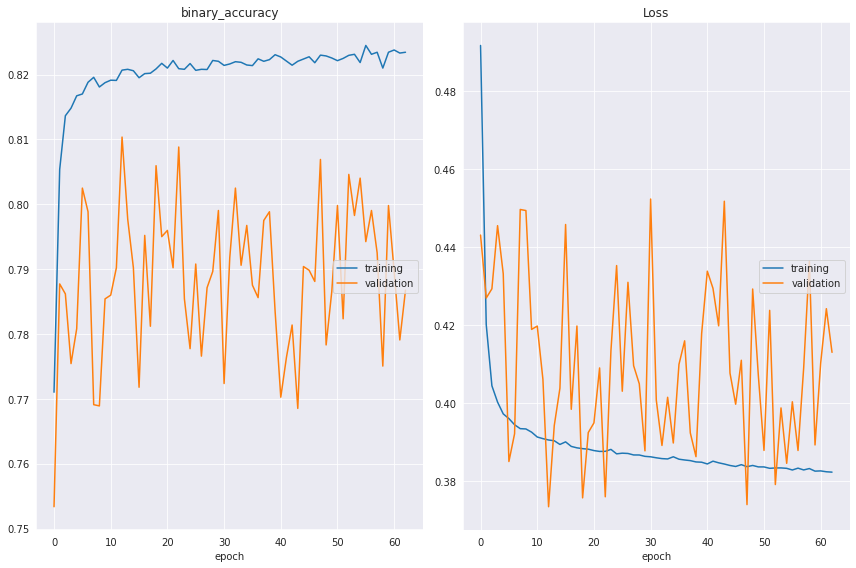

binary_accuracy
	training         	 (min:    0.771, max:    0.824, cur:    0.823)
	validation       	 (min:    0.753, max:    0.810, cur:    0.787)
Loss
	training         	 (min:    0.382, max:    0.492, cur:    0.382)
	validation       	 (min:    0.373, max:    0.452, cur:    0.413)


In [ ]:
with tf.device('/CPU:0'):

    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_adult = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_adult.fit(X_train_adult,
                                      y_train_adult, 
                                      epochs=config['lambda_net']['epochs_lambda'], 
                                      batch_size=config['lambda_net']['batch_lambda'], 
                                      callbacks=[early_stopping, PlotLossesKerasTF()],
                                      validation_data=(X_valid_adult, y_valid_adult),
                                      verbose=0)



In [ ]:
test_network_adult.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_network_adult_parameters = shaped_network_parameters_to_array(test_network_adult.get_weights(), config)

start_inet = time.time() 

test_network_adult_dt_inet = model.predict(np.array([test_network_adult_parameters]))[0]

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [ ]:
if dt_type == 'vanilla':
    dataset_size_list_adult = [1_000, 5_000, 10_000, 100_000, 1_000_000, config['evaluation']['per_network_optimization_dataset_size'], 'TRAIN_DATA']
else:
    dataset_size_list_adult = [1_000, 10_000, config['evaluation']['per_network_optimization_dataset_size'], 'TRAIN_DATA']
    
results_adult_list = []
dt_distilled_adult_list = []
for dataset_size in dataset_size_list_adult:
    
    if dataset_size == 'TRAIN_DATA': 
        results_adult, dt_distilled_adult = evaluate_interpretation_net_prediction_single_sample(test_network_adult_parameters, 
                                                                           test_network_adult_dt_inet,
                                                                           X_test_adult.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_adult.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_adult, dt_distilled_adult = evaluate_interpretation_net_prediction_single_sample(test_network_adult_parameters, 
                                                                           test_network_adult_dt_inet,
                                                                           X_test_adult.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_adult['inet_scores']['runtime'] = inet_runtime
    results_adult_list.append(results_adult)
    dt_distilled_adult_list.append(dt_distilled_adult)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_adult['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_adult['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_adult['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy',  np.round(results_adult['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_adult['dt_scores']['binary_crossentropy'], 3), np.round(results_adult['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_adult['dt_scores']['accuracy_data_random'], 3), np.round(results_adult['dt_scores']['accuracy'], 3), np.round(results_adult['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_adult['dt_scores']['f1_score_data_random'], 3), np.round(results_adult['dt_scores']['f1_score'], 3), np.round(results_adult['inet_scores']['f1_score'], 3)],
            ['Runtime',  np.round(results_adult['dt_scores']['runtime'], 3), np.round(results_adult['dt_scores']['runtime'], 3), np.round(results_adult['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')             
        
adult_evaluation_result_dict = None
for some_dict in results_adult_list:
    if adult_evaluation_result_dict == None:
        adult_evaluation_result_dict = some_dict
    else:
        adult_evaluation_result_dict = mergeDict(adult_evaluation_result_dict, some_dict)

adult_evaluation_result_dict['dataset_size'] = dataset_size_list_adult
                

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 1000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.341               |          0.643           |        0.681         |
|   Binary Crossentropy    |              0.034               |          0.747           |        1.931         |
|         Accuracy         |              0.992               |          0.717           |        0.624         |
|         F1 Score         |              0.996               |          0.728           |        0.039         |
|         Runtime          |              44.373              |          44.373          |        0.303         |
+--------------------------+----------------------------------+----

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 10000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.338               |          0.591           |        0.681         |
|   Binary Crossentropy    |              0.035               |          0.511           |        1.931         |
|         Accuracy         |               0.99               |          0.862           |        0.624         |
|         F1 Score         |              0.995               |          0.843           |        0.039         |
|         Runtime          |             361.235              |         361.235          |        0.303         |
+--------------------------+----------------------------------+---

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 5000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.338               |          0.732           |        0.681         |
|   Binary Crossentropy    |              0.043               |          1.046           |        1.931         |
|         Accuracy         |              0.989               |          0.617           |        0.624         |
|         F1 Score         |              0.994               |          0.666           |        0.039         |
|         Runtime          |             177.406              |         177.406          |        0.303         |
+--------------------------+----------------------------------+----

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 TRAIN_DATA
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.525               |          0.528           |        0.681         |
|   Binary Crossentropy    |              0.248               |          0.278           |        1.931         |
|         Accuracy         |              0.912               |          0.907           |        0.624         |
|         F1 Score         |              0.923               |          0.886           |        0.039         |
|         Runtime          |             990.002              |         990.002          |        0.303         |
+--------------------------+---------------------------------

In [ ]:
mean = np.mean(lambda_net_dataset_train.network_parameters_array, axis=0)
std = np.std(lambda_net_dataset_train.network_parameters_array, axis=0)

z_score = (test_network_adult_parameters-mean)/std
z_score_aggregate = np.sum(np.abs(z_score))

print('Z-Score (Sample to Train Data):\t\t', np.round(z_score_aggregate, 3), '\t', '(' + str(np.round(z_score_average_train, 3)) + ' for Train)')

initialization_array = shaped_network_parameters_to_array(generate_base_model(config).get_weights(), config)

distance_to_initialization = test_network_adult_parameters - initialization_array
distance_to_initialization_aggregate = np.sum(np.abs(distance_to_initialization))

print('Distance to Initialization:\t\t', np.round(distance_to_initialization_aggregate, 3), '\t', '(' + str(np.round(distance_to_initialization_average_train, 3)) + ' for Train)')   

distance_to_sample_aggregate_list = []
for sample in lambda_net_dataset_train.network_parameters_array:
    distance_to_sample = test_network_adult_parameters - sample
    distance_to_sample_aggregate = np.sum(np.abs(distance_to_sample))
    distance_to_sample_aggregate_list.append(distance_to_sample_aggregate)

distance_to_sample_average = np.mean(distance_to_sample_aggregate_list)
distance_to_sample_min = np.min(distance_to_sample_aggregate_list)

print('Average Distance to Train Data:\t\t', np.round(distance_to_sample_average, 3), '\t', '(' + str(np.round(distance_to_sample_average_average_train, 3)) + ' for Train)')   
print('Distance to closest Train Data Sample:\t', np.round(distance_to_sample_min, 3), '\t', '(' + str(np.round(distance_to_sample_min_average_train, 3)) + ' for Train)')   
 

Z-Score (Sample to Train Data):		 nan 	 (nan for Train)
Distance to Initialization:		 385.465 	 (304.694 for Train)
Average Distance to Train Data:		 528.109 	 (426.834 for Train)
Distance to closest Train Data Sample:	 362.258 	 (0.0 for Train)


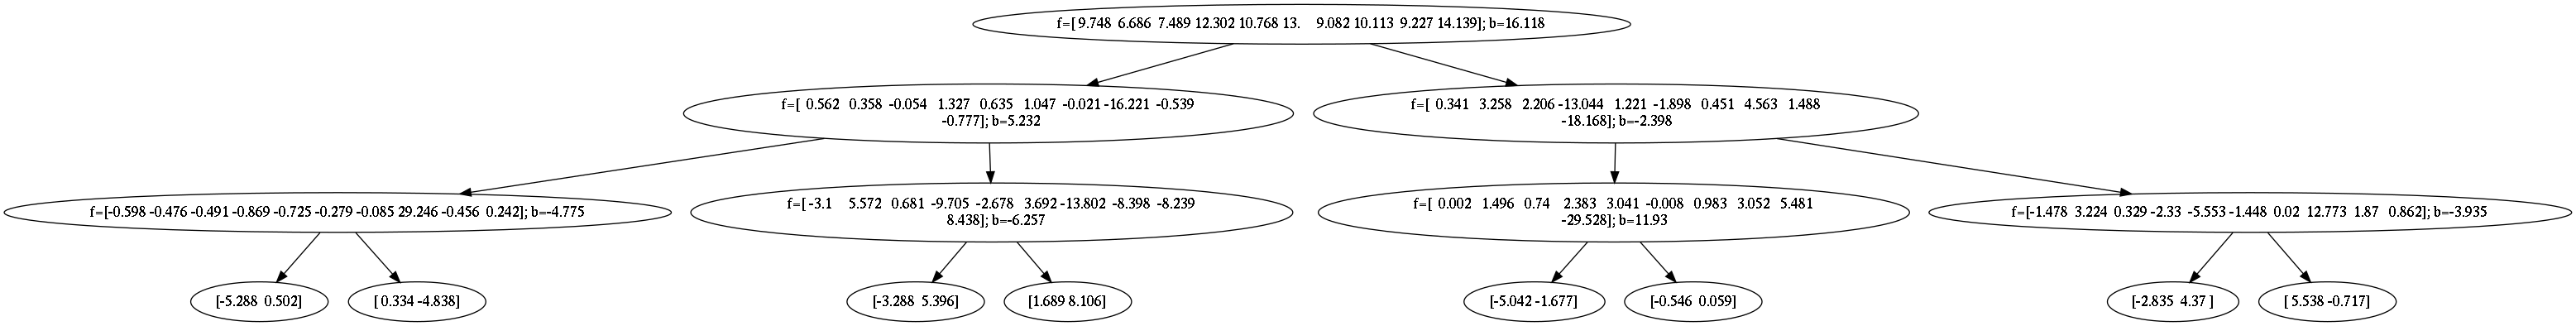

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_adult_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_adult_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

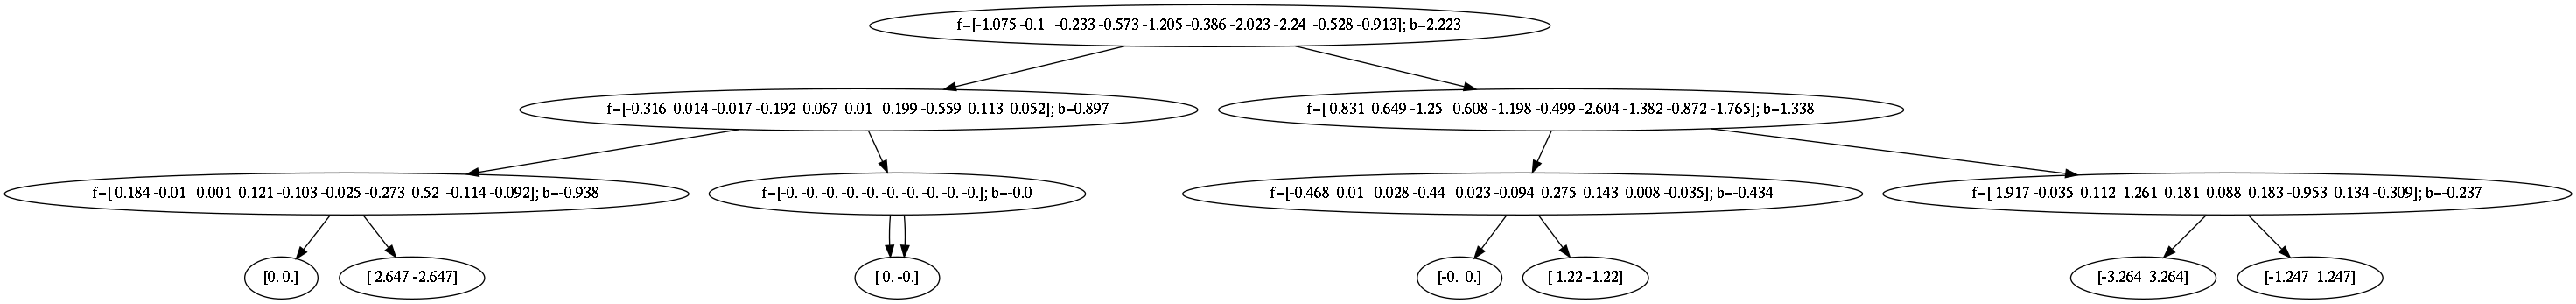

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_adult, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_adult.plot_tree()
image

## Titanic Dataset

In [ ]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [ ]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,891.000,714.000,891.000,891.000,891.000
mean,446.000,0.384,2.309,29.699,0.523,0.382,32.204
std,257.354,0.487,0.836,14.526,1.103,0.806,49.693
min,1.000,0.000,1.000,0.420,0.000,0.000,0.000
25%,223.500,0.000,2.000,20.125,0.000,0.000,7.910
50%,446.000,0.000,3.000,28.000,0.000,0.000,14.454
75%,668.500,1.000,3.000,38.000,1.000,0.000,31.000
max,891.000,1.000,3.000,80.000,8.000,6.000,512.329


In [ ]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanic_data = titanic_data.drop([
                                    'Cabin', 
                                    'Ticket', 
                                    'Name', 
                                    'PassengerId'
                                ], axis = 1)


In [ ]:
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [ ]:
titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000,1,0,7.250,S
1,1,1,female,38.000,1,0,71.283,C
2,1,3,female,26.000,0,0,7.925,S
3,1,1,female,35.000,1,0,53.100,S
4,0,3,male,35.000,0,0,8.050,S


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
features_select = [
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

categorical_features = ['Embarked']#[1, 2, 7]
ordinal_features = ['Sex']

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(titanic_data)

titanic_data = transformer.transform(titanic_data)
titanic_data = pd.DataFrame(titanic_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    titanic_data[ordinal_feature] = OrdinalEncoder().fit_transform(titanic_data[ordinal_feature].values.reshape(-1, 1)).flatten()

titanic_data = titanic_data.astype(np.float64)

    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']
X_data_titanic.head()

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare
0,0.000,0.000,1.000,1.000,3.000,22.000,1.000,0.000,7.250
1,1.000,0.000,0.000,0.000,1.000,38.000,1.000,0.000,71.283
2,0.000,0.000,1.000,0.000,3.000,26.000,0.000,0.000,7.925
3,0.000,0.000,1.000,0.000,1.000,35.000,1.000,0.000,53.100
4,0.000,0.000,1.000,1.000,3.000,35.000,0.000,0.000,8.050


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
if X_data_titanic.shape[1] > number_of_variables:
    #X_data_titanic = X_data_titanic.sample(n=number_of_variables,axis='columns')
    
    clf_titanic = ExtraTreesClassifier(n_estimators=100)
    clf_titanic = clf_titanic.fit(X_data_titanic, y_data_titanic)

    selector_titanic = SelectFromModel(clf_titanic, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_titanic.get_support()   
    X_data_titanic = X_data_titanic.loc[:,feature_idx]    
else:
    for i in range(number_of_variables-X_data_titanic.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_titanic[column_name] = np.zeros(X_data_titanic.shape[0])
X_data_titanic.head()

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare,zero_dummy_1
0,0.000,0.000,1.000,1.000,3.000,22.000,1.000,0.000,7.250,0.000
1,1.000,0.000,0.000,0.000,1.000,38.000,1.000,0.000,71.283,0.000
2,0.000,0.000,1.000,0.000,3.000,26.000,0.000,0.000,7.925,0.000
3,0.000,0.000,1.000,0.000,1.000,35.000,1.000,0.000,53.100,0.000
4,0.000,0.000,1.000,1.000,3.000,35.000,0.000,0.000,8.050,0.000


In [ ]:
normalizer_list = []
for column_name in X_data_titanic:
    scaler = MinMaxScaler()
    scaler.fit(X_data_titanic[column_name].values.reshape(-1, 1))
    X_data_titanic[column_name] = scaler.transform(X_data_titanic[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_titanic.head()

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare,zero_dummy_1
0,0.000,0.000,1.000,1.000,1.000,0.271,0.125,0.000,0.014,0.000
1,1.000,0.000,0.000,0.000,0.000,0.472,0.125,0.000,0.139,0.000
2,0.000,0.000,1.000,0.000,1.000,0.321,0.000,0.000,0.015,0.000
3,0.000,0.000,1.000,0.000,0.000,0.435,0.125,0.000,0.104,0.000
4,0.000,0.000,1.000,1.000,1.000,0.435,0.000,0.000,0.016,0.000


In [ ]:
y_data_titanic

0     0.000
1     1.000
2     1.000
3     1.000
4     0.000
       ... 
886   0.000
887   1.000
888   0.000
889   1.000
890   0.000
Name: Survived, Length: 891, dtype: float64

In [ ]:
X_train_titanic_with_valid, X_test_titanic, y_train_titanic_with_valid, y_test_titanic = train_test_split(X_data_titanic, y_data_titanic, train_size=0.8, random_state=RANDOM_SEED)
X_train_titanic, X_valid_titanic, y_train_titanic, y_valid_titanic = train_test_split(X_train_titanic_with_valid, y_train_titanic_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_titanic.shape, y_train_titanic.shape)
print(X_valid_titanic.shape, y_valid_titanic.shape)
print(X_test_titanic.shape, y_test_titanic.shape)

(569, 10) (569,)
(143, 10) (143,)
(179, 10) (179,)


In [ ]:
true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

True Ratio:  0.37258347978910367


In [ ]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_titanic, y_train_titanic = oversample.fit_resample(X_train_titanic, y_train_titanic)

    true_labels = len(y_train_titanic[y_train_titanic >= 0.5 ]) 
    false_labels = len(y_train_titanic[y_train_titanic < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

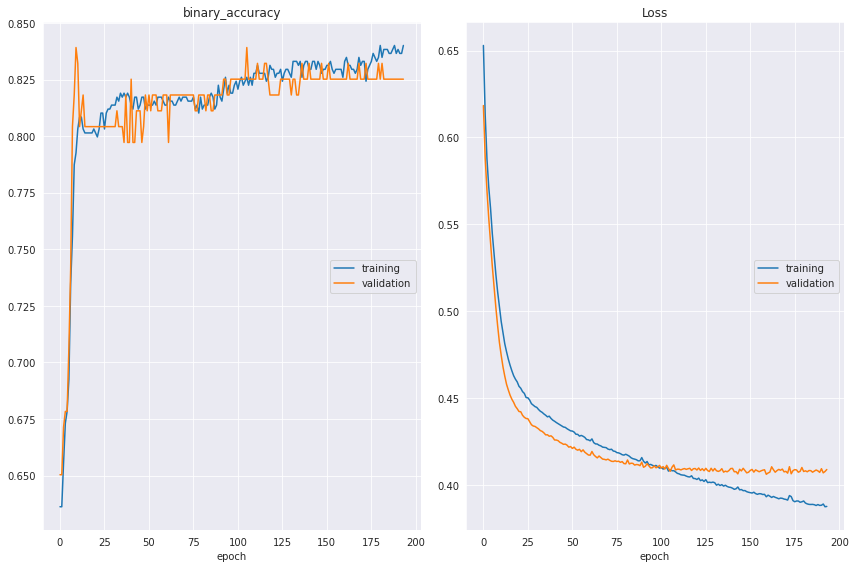

binary_accuracy
	training         	 (min:    0.636, max:    0.840, cur:    0.840)
	validation       	 (min:    0.650, max:    0.839, cur:    0.825)
Loss
	training         	 (min:    0.387, max:    0.653, cur:    0.388)
	validation       	 (min:    0.406, max:    0.618, cur:    0.409)


In [ ]:
with tf.device('/CPU:0'):

    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_titanic = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_titanic.fit(X_train_titanic,
                                          y_train_titanic, 
                                          epochs=config['lambda_net']['epochs_lambda'], 
                                          batch_size=config['lambda_net']['batch_lambda'], 
                                          callbacks=[early_stopping, PlotLossesKerasTF()],
                                          validation_data=(X_valid_titanic, y_valid_titanic),
                                          verbose=0)



In [ ]:
test_network_titanic.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_network_titanic_parameters = shaped_network_parameters_to_array(test_network_titanic.get_weights(), config)

start_inet = time.time() 

test_network_titanic_dt_inet = model.predict(np.array([test_network_titanic_parameters]))[0]

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [ ]:
if dt_type == 'vanilla':
    dataset_size_list_titanic = [1_000, 5_000, 10_000, 100_000, 1_000_000, config['evaluation']['per_network_optimization_dataset_size'], 'TRAIN_DATA']
else:
    dataset_size_list_titanic = [1_000, 10_000, config['evaluation']['per_network_optimization_dataset_size'], 'TRAIN_DATA']
    
results_titanic_list = []
dt_distilled_titanic_list = []
for dataset_size in dataset_size_list_titanic:
    
    if dataset_size == 'TRAIN_DATA': 
        results_titanic, dt_distilled_titanic = evaluate_interpretation_net_prediction_single_sample(test_network_titanic_parameters, 
                                                                           test_network_titanic_dt_inet,
                                                                           X_test_titanic.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_titanic.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_titanic, dt_distilled_titanic = evaluate_interpretation_net_prediction_single_sample(test_network_titanic_parameters, 
                                                                           test_network_titanic_dt_inet,
                                                                           X_test_titanic.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_titanic['inet_scores']['runtime'] = inet_runtime
    results_titanic_list.append(results_titanic)
    dt_distilled_titanic_list.append(dt_distilled_titanic)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_titanic['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_titanic['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_titanic['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy', np.round(results_titanic['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_titanic['dt_scores']['binary_crossentropy'], 3), np.round(results_titanic['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_titanic['dt_scores']['accuracy_data_random'], 3), np.round(results_titanic['dt_scores']['accuracy'], 3), np.round(results_titanic['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_titanic['dt_scores']['f1_score_data_random'], 3), np.round(results_titanic['dt_scores']['f1_score'], 3), np.round(results_titanic['inet_scores']['f1_score'], 3)],
            ['Runtime',  np.round(results_titanic['dt_scores']['runtime'], 3), np.round(results_titanic['dt_scores']['runtime'], 3), np.round(results_titanic['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')        
        
titanic_evaluation_result_dict = None
for some_dict in results_titanic_list:
    if titanic_evaluation_result_dict == None:
        titanic_evaluation_result_dict = some_dict
    else:
        titanic_evaluation_result_dict = mergeDict(titanic_evaluation_result_dict, some_dict)

titanic_evaluation_result_dict['dataset_size'] = dataset_size_list_titanic
                

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 1000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.551               |          0.562           |        0.553         |
|   Binary Crossentropy    |              0.235               |          0.484           |        0.359         |
|         Accuracy         |              0.919               |          0.765           |         0.86         |
|         F1 Score         |              0.919               |          0.747           |        0.775         |
|         Runtime          |              36.145              |          36.145          |        0.128         |
+--------------------------+----------------------------------+----

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 10000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.531               |          0.569           |        0.553         |
|   Binary Crossentropy    |              0.164               |          0.569           |        0.359         |
|         Accuracy         |              0.951               |          0.793           |         0.86         |
|         F1 Score         |              0.954               |          0.773           |        0.775         |
|         Runtime          |             353.686              |         353.686          |        0.128         |
+--------------------------+----------------------------------+---

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 5000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |               0.53               |          0.562           |        0.553         |
|   Binary Crossentropy    |              0.165               |          0.485           |        0.359         |
|         Accuracy         |              0.952               |          0.838           |         0.86         |
|         F1 Score         |              0.955               |          0.813           |        0.775         |
|         Runtime          |             178.978              |         178.978          |        0.128         |
+--------------------------+----------------------------------+----

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 TRAIN_DATA
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.498               |          0.495           |        0.553         |
|   Binary Crossentropy    |              0.098               |           0.13           |        0.359         |
|         Accuracy         |              0.974               |          0.961           |         0.86         |
|         F1 Score         |              0.958               |          0.947           |        0.775         |
|         Runtime          |              20.435              |          20.435          |        0.128         |
+--------------------------+---------------------------------

In [ ]:
mean = np.mean(lambda_net_dataset_train.network_parameters_array, axis=0)
std = np.std(lambda_net_dataset_train.network_parameters_array, axis=0)

z_score = (test_network_titanic_parameters-mean)/std
z_score_aggregate = np.sum(np.abs(z_score))

print('Z-Score (Sample to Train Data):\t\t', np.round(z_score_aggregate, 3), '\t', '(' + str(np.round(z_score_average_train, 3)) + ' for Train)')

initialization_array = shaped_network_parameters_to_array(generate_base_model(config).get_weights(), config)

distance_to_initialization = test_network_titanic_parameters - initialization_array
distance_to_initialization_aggregate = np.sum(np.abs(distance_to_initialization))

print('Distance to Initialization:\t\t', np.round(distance_to_initialization_aggregate, 3), '\t', '(' + str(np.round(distance_to_initialization_average_train, 3)) + ' for Train)')   

distance_to_sample_aggregate_list = []
for sample in lambda_net_dataset_train.network_parameters_array:
    distance_to_sample = test_network_titanic_parameters - sample
    distance_to_sample_aggregate = np.sum(np.abs(distance_to_sample))
    distance_to_sample_aggregate_list.append(distance_to_sample_aggregate)

distance_to_sample_average = np.mean(distance_to_sample_aggregate_list)
distance_to_sample_min = np.min(distance_to_sample_aggregate_list)

print('Average Distance to Train Data:\t\t', np.round(distance_to_sample_average, 3), '\t', '(' + str(np.round(distance_to_sample_average_average_train, 3)) + ' for Train)')   
print('Distance to closest Train Data Sample:\t', np.round(distance_to_sample_min, 3), '\t', '(' + str(np.round(distance_to_sample_min_average_train, 3)) + ' for Train)')   


Z-Score (Sample to Train Data):		 nan 	 (nan for Train)
Distance to Initialization:		 175.567 	 (304.694 for Train)
Average Distance to Train Data:		 365.392 	 (426.834 for Train)
Distance to closest Train Data Sample:	 194.289 	 (0.0 for Train)


In [ ]:
X_data_titanic.head(5)

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare,zero_dummy_1
0,0.000,0.000,1.000,1.000,1.000,0.271,0.125,0.000,0.014,0.000
1,1.000,0.000,0.000,0.000,0.000,0.472,0.125,0.000,0.139,0.000
2,0.000,0.000,1.000,0.000,1.000,0.321,0.000,0.000,0.015,0.000
3,0.000,0.000,1.000,0.000,0.000,0.435,0.125,0.000,0.104,0.000
4,0.000,0.000,1.000,1.000,1.000,0.435,0.000,0.000,0.016,0.000


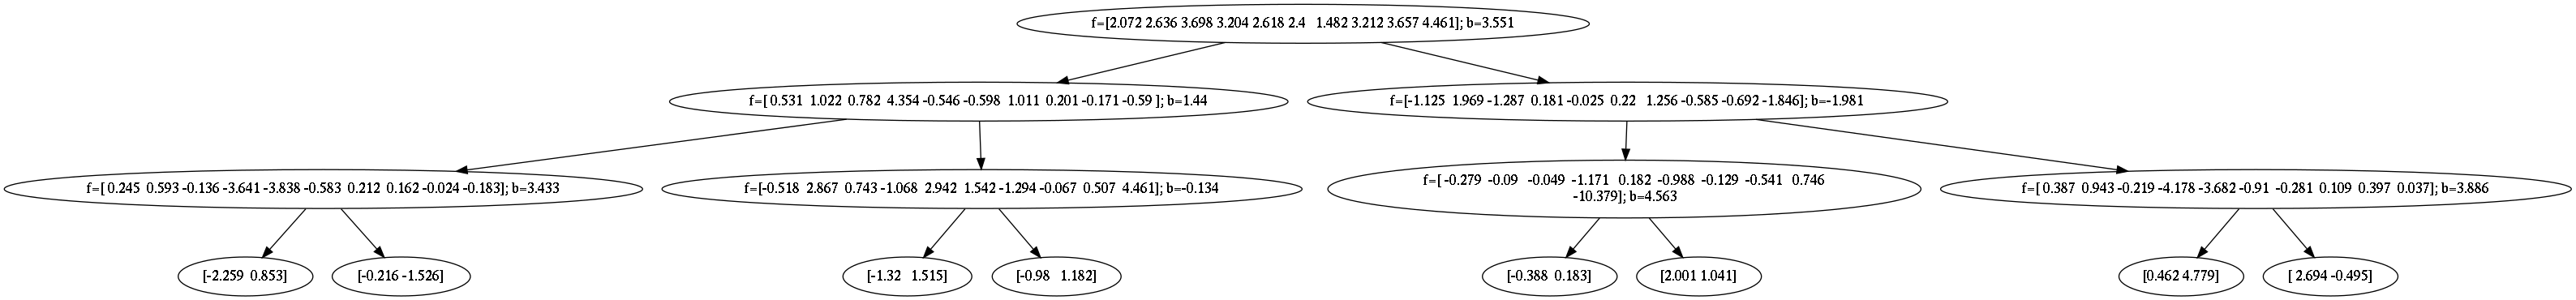

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_titanic_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_titanic_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

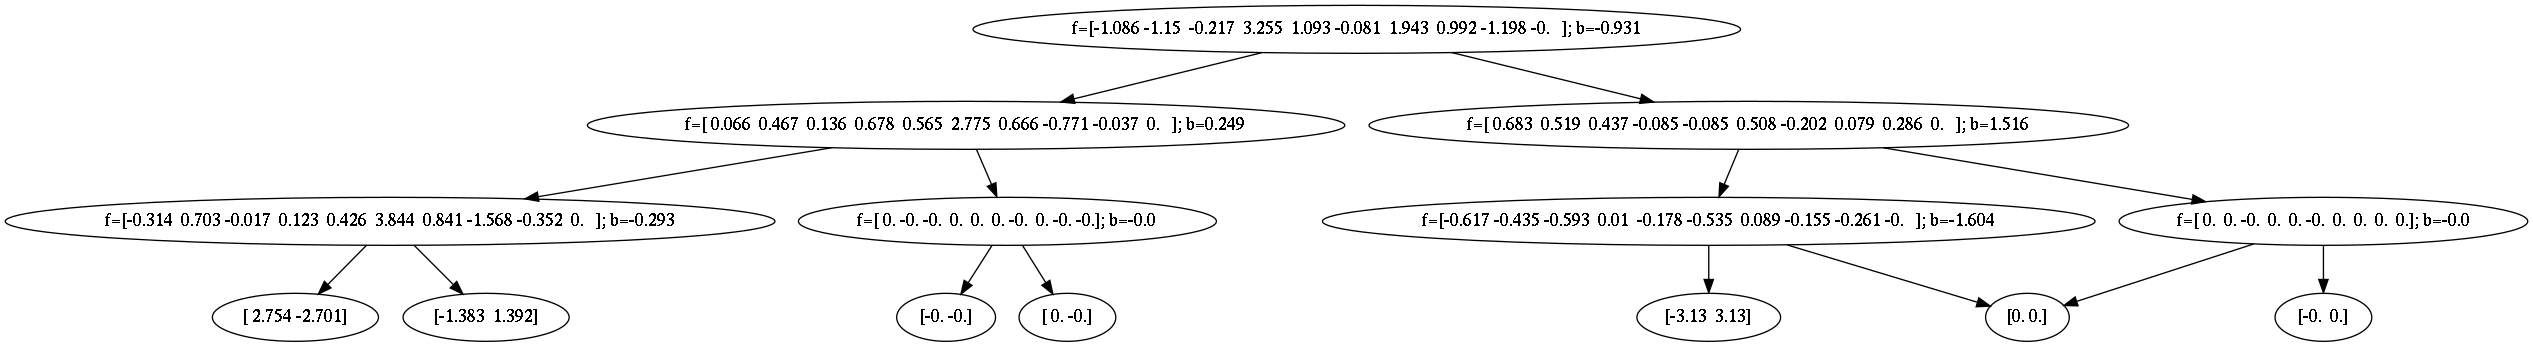

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_titanic, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_titanic.plot_tree()
image

## Absenteeism at Work Dataset

In [ ]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

absenteeism_data.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [ ]:
absenteeism_data.describe()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000
mean,18.018,19.216,6.324,3.915,2.545,221.330,29.631,12.554,36.450,271.490,94.588,0.054,1.292,1.019,0.568,0.073,0.746,79.035,172.115,26.677,6.924
std,11.021,8.433,3.436,1.422,1.112,66.952,14.837,4.385,6.479,39.058,3.779,0.226,0.673,1.098,0.496,0.260,1.318,12.883,6.035,4.285,13.331
min,1.000,0.000,0.000,2.000,1.000,118.000,5.000,1.000,27.000,205.917,81.000,0.000,1.000,0.000,0.000,0.000,0.000,56.000,163.000,19.000,0.000
25%,9.000,13.000,3.000,3.000,2.000,179.000,16.000,9.000,31.000,244.387,93.000,0.000,1.000,0.000,0.000,0.000,0.000,69.000,169.000,24.000,2.000
50%,18.000,23.000,6.000,4.000,3.000,225.000,26.000,13.000,37.000,264.249,95.000,0.000,1.000,1.000,1.000,0.000,0.000,83.000,170.000,25.000,3.000
75%,28.000,26.000,9.000,5.000,4.000,260.000,50.000,16.000,40.000,294.217,97.000,0.000,1.000,2.000,1.000,0.000,1.000,89.000,172.000,31.000,8.000
max,36.000,28.000,12.000,6.000,4.000,388.000,52.000,29.000,58.000,378.884,100.000,1.000,4.000,4.000,1.000,1.000,8.000,108.000,196.000,38.000,120.000


In [ ]:
absenteeism_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [ ]:
absenteeism_data.isnull().sum()

ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

In [ ]:
features_select = [
                           'Disciplinary failure', #CATEGORICAL
                           'Social drinker', #CATEGORICAL
                           'Social smoker', #CATEGORICAL
                           'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           'Hit target',
                           'Education', 
                           'Son', 
                           'Pet', 
                           'Weight', 
                           'Height', 
                           'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

categorical_features = []#[1, 2, 7]
ordinal_features = []

transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_features)], remainder='passthrough', sparse_threshold=0)
transformer.fit(absenteeism_data)

absenteeism_data = transformer.transform(absenteeism_data)
absenteeism_data = pd.DataFrame(absenteeism_data, columns=transformer.get_feature_names())

for ordinal_feature in ordinal_features:
    absenteeism_data[ordinal_feature] = OrdinalEncoder().fit_transform(absenteeism_data[ordinal_feature].values.reshape(-1, 1)).flatten()

absenteeism_data = absenteeism_data.astype(np.float64)

    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 4) * 1) #absenteeism_data['Absenteeism time in hours']

print(X_data_absenteeism.shape)

X_data_absenteeism.head()

(740, 15)


,Disciplinary failure,Social drinker,Social smoker,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Education,Son,Pet,Weight,Height,Body mass index
0,0.000,1.000,0.000,289.000,36.000,13.000,33.000,239.554,97.000,1.000,2.000,1.000,90.000,172.000,30.000
1,1.000,1.000,0.000,118.000,13.000,18.000,50.000,239.554,97.000,1.000,1.000,0.000,98.000,178.000,31.000
2,0.000,1.000,0.000,179.000,51.000,18.000,38.000,239.554,97.000,1.000,0.000,0.000,89.000,170.000,31.000
3,0.000,1.000,1.000,279.000,5.000,14.000,39.000,239.554,97.000,1.000,2.000,0.000,68.000,168.000,24.000
4,0.000,1.000,0.000,289.000,36.000,13.000,33.000,239.554,97.000,1.000,2.000,1.000,90.000,172.000,30.000


    3. Month of absence
    4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
    5. Seasons (summer (1), autumn (2), winter (3), spring (4))
    6. Transportation expense
    7. Distance from Residence to Work (kilometers)
    8. Service time
    9. Age
    10. Work load Average/day
    11. Hit target
    12. Disciplinary failure (yes=1; no=0)
    13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
    14. Son (number of children)
    15. Social drinker (yes=1; no=0)
    16. Social smoker (yes=1; no=0)
    17. Pet (number of pet)
    18. Weight
    19. Height
    20. Body mass index
    21. Absenteeism time in hours (target)

In [ ]:
if X_data_absenteeism.shape[1] > number_of_variables:
    #X_data_absenteeism = X_data_absenteeism.sample(n=number_of_variables,axis='columns')
    
    clf_absenteeism = ExtraTreesClassifier(n_estimators=100)
    clf_absenteeism = clf_absenteeism.fit(X_data_absenteeism, y_data_absenteeism)

    selector_absenteeism = SelectFromModel(clf_absenteeism, 
                                     prefit=True,
                                     threshold=-np.inf,
                                     max_features=number_of_variables)
    feature_idx = selector_absenteeism.get_support()   
    X_data_absenteeism = X_data_absenteeism.loc[:,feature_idx]        
else:
    for i in range(number_of_variables-X_data_absenteeism.shape[1]):
        column_name = 'zero_dummy_' + str(i+1)
        X_data_absenteeism[column_name] = np.zeros(X_data_absenteeism.shape[0])
X_data_absenteeism.head()

,Disciplinary failure,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Weight,Body mass index
0,0.000,289.000,36.000,13.000,33.000,239.554,97.000,2.000,90.000,30.000
1,1.000,118.000,13.000,18.000,50.000,239.554,97.000,1.000,98.000,31.000
2,0.000,179.000,51.000,18.000,38.000,239.554,97.000,0.000,89.000,31.000
3,0.000,279.000,5.000,14.000,39.000,239.554,97.000,2.000,68.000,24.000
4,0.000,289.000,36.000,13.000,33.000,239.554,97.000,2.000,90.000,30.000


In [ ]:
normalizer_list = []
for column_name in X_data_absenteeism:
    scaler = MinMaxScaler()
    scaler.fit(X_data_absenteeism[column_name].values.reshape(-1, 1))
    X_data_absenteeism[column_name] = scaler.transform(X_data_absenteeism[column_name].values.reshape(-1, 1)).ravel()
    normalizer_list.append(scaler)
X_data_absenteeism.head()

,Disciplinary failure,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Son,Weight,Body mass index
0,0.000,0.633,0.660,0.429,0.194,0.194,0.842,0.500,0.654,0.579
1,1.000,0.000,0.170,0.607,0.742,0.194,0.842,0.250,0.808,0.632
2,0.000,0.226,0.979,0.607,0.355,0.194,0.842,0.000,0.635,0.632
3,0.000,0.596,0.000,0.464,0.387,0.194,0.842,0.500,0.231,0.263
4,0.000,0.633,0.660,0.429,0.194,0.194,0.842,0.500,0.654,0.579


In [ ]:
y_data_absenteeism

0      0
1      0
2      0
3      0
4      0
      ..
735    1
736    0
737    0
738    0
739    0
Name: Absenteeism time in hours, Length: 740, dtype: int64

In [ ]:
X_train_absenteeism_with_valid, X_test_absenteeism, y_train_absenteeism_with_valid, y_test_absenteeism = train_test_split(X_data_absenteeism, y_data_absenteeism, train_size=0.8, random_state=RANDOM_SEED)
X_train_absenteeism, X_valid_absenteeism, y_train_absenteeism, y_valid_absenteeism = train_test_split(X_train_absenteeism_with_valid, y_train_absenteeism_with_valid, train_size=0.8, random_state=RANDOM_SEED)

print(X_train_absenteeism.shape, y_train_absenteeism.shape)
print(X_valid_absenteeism.shape, y_valid_absenteeism.shape)
print(X_test_absenteeism.shape, y_test_absenteeism.shape)

(473, 10) (473,)
(119, 10) (119,)
(148, 10) (148,)


In [ ]:
true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

true_ratio = true_labels/(true_labels+false_labels)

print('True Ratio: ', str(true_ratio))

True Ratio:  0.38054968287526425


In [ ]:
if true_ratio <= 0.3 or true_ratio >= 0.7:
    from imblearn.over_sampling import RandomOverSampler 

    oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)

    X_train_absenteeism, y_train_absenteeism = oversample.fit_resample(X_train_absenteeism, y_train_absenteeism)

    true_labels = len(y_train_absenteeism[y_train_absenteeism >= 0.5 ]) 
    false_labels = len(y_train_absenteeism[y_train_absenteeism < 0.5 ]) 

    print('True Ratio: ', str(true_labels/(true_labels+false_labels)))

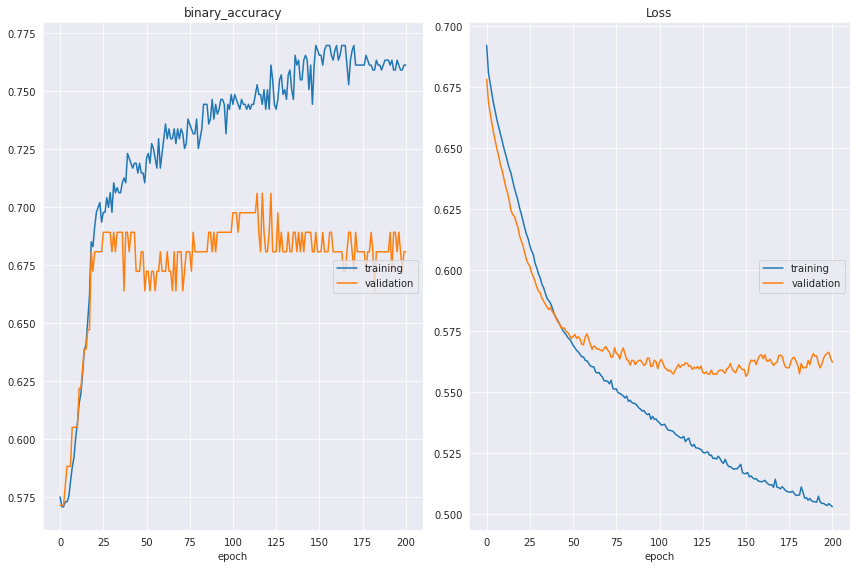

binary_accuracy
	training         	 (min:    0.571, max:    0.770, cur:    0.761)
	validation       	 (min:    0.571, max:    0.706, cur:    0.681)
Loss
	training         	 (min:    0.503, max:    0.692, cur:    0.503)
	validation       	 (min:    0.557, max:    0.678, cur:    0.562)


In [ ]:
with tf.device('/CPU:0'):
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED)

    test_network_absenteeism = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=50, 
                                                      min_delta=0.001, 
                                                      verbose=0, 
                                                      mode='min', 
                                                      restore_best_weights=False)

    model_history = test_network_absenteeism.fit(X_train_absenteeism,
                                      y_train_absenteeism, 
                                      epochs=config['lambda_net']['epochs_lambda'], 
                                      batch_size=config['lambda_net']['batch_lambda'], 
                                      callbacks=[early_stopping, PlotLossesKerasTF()],
                                      validation_data=(X_valid_absenteeism, y_valid_absenteeism),
                                      verbose=0)



In [ ]:
test_network_absenteeism.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 129       
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
test_network_absenteeism_parameters = shaped_network_parameters_to_array(test_network_absenteeism.get_weights(), config)

start_inet = time.time() 

test_network_absenteeism_dt_inet = model.predict(np.array([test_network_absenteeism_parameters]))[0]

end_inet = time.time()     
inet_runtime = (end_inet - start_inet)   

In [ ]:
if dt_type == 'vanilla':
    dataset_size_list_absenteeism = [1_000, 5_000, 10_000, 100_000, 1_000_000, config['evaluation']['per_network_optimization_dataset_size'], 'TRAIN_DATA']
else:
    dataset_size_list_absenteeism = [1_000, 10_000, config['evaluation']['per_network_optimization_dataset_size'], 'TRAIN_DATA']

results_absenteeism_list = []
dt_distilled_absenteeism_list = []
for dataset_size in dataset_size_list_absenteeism:
    
    if dataset_size == 'TRAIN_DATA': 
        results_absenteeism, dt_distilled_absenteeism = evaluate_interpretation_net_prediction_single_sample(test_network_absenteeism_parameters, 
                                                                           test_network_absenteeism_dt_inet,
                                                                           X_test_absenteeism.values, 
                                                                           #y_test_lambda,
                                                                           config,
                                                                           train_data=X_train_absenteeism.values)
    
    else:
        config_test = deepcopy(config)
        config_test['evaluation']['per_network_optimization_dataset_size'] = dataset_size

        results_absenteeism, dt_distilled_absenteeism = evaluate_interpretation_net_prediction_single_sample(test_network_absenteeism_parameters, 
                                                                           test_network_absenteeism_dt_inet,
                                                                           X_test_absenteeism.values, 
                                                                           #y_test_lambda,
                                                                           config_test)

        
    results_absenteeism['inet_scores']['runtime'] = inet_runtime
    results_absenteeism_list.append(results_absenteeism)
    dt_distilled_absenteeism_list.append(dt_distilled_absenteeism)
    
    print('Dataset Size:\t\t', dataset_size)
    tab = PrettyTable()
    tab.field_names = ['Metric', 'Distilled DT (Train/Random Data)', 'Distilled DT (Test Data)', 'I-Net DT (Test Data)']
    tab.add_rows(
        [
            ['Soft Binary Crossentropy', np.round(results_absenteeism['dt_scores']['soft_binary_crossentropy_data_random'], 3), np.round(results_absenteeism['dt_scores']['soft_binary_crossentropy'], 3), np.round(results_absenteeism['inet_scores']['soft_binary_crossentropy'], 3)],
            ['Binary Crossentropy', np.round(results_absenteeism['dt_scores']['binary_crossentropy_data_random'], 3), np.round(results_absenteeism['dt_scores']['binary_crossentropy'], 3), np.round(results_absenteeism['inet_scores']['binary_crossentropy'], 3)],
            ['Accuracy', np.round(results_absenteeism['dt_scores']['accuracy_data_random'], 3), np.round(results_absenteeism['dt_scores']['accuracy'], 3), np.round(results_absenteeism['inet_scores']['accuracy'], 3)],
            ['F1 Score', np.round(results_absenteeism['dt_scores']['f1_score_data_random'], 3), np.round(results_absenteeism['dt_scores']['f1_score'], 3), np.round(results_absenteeism['inet_scores']['f1_score'], 3)],
            ['Runtime', np.round(results_absenteeism['dt_scores']['runtime'], 3), np.round(results_absenteeism['dt_scores']['runtime'], 3), np.round(results_absenteeism['inet_scores']['runtime'], 3)],
        ]    
    )
    print(tab)
    print('-------------------------------------------------------------------------------------------------------------------------------------------------------------------------')        
        
absenteeism_evaluation_result_dict = None
for some_dict in results_absenteeism_list:
    if absenteeism_evaluation_result_dict == None:
        absenteeism_evaluation_result_dict = some_dict
    else:
        absenteeism_evaluation_result_dict = mergeDict(absenteeism_evaluation_result_dict, some_dict)

absenteeism_evaluation_result_dict['dataset_size'] = dataset_size_list_absenteeism
                

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 1000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.433               |          0.628           |        0.722         |
|   Binary Crossentropy    |              0.125               |          0.559           |        0.821         |
|         Accuracy         |              0.953               |          0.716           |        0.561         |
|         F1 Score         |              0.751               |          0.562           |        0.575         |
|         Runtime          |              37.103              |          37.103          |         8.67         |
+--------------------------+----------------------------------+----

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 5000
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.416               |          0.597           |        0.722         |
|   Binary Crossentropy    |              0.059               |          0.391           |        0.821         |
|         Accuracy         |              0.984               |          0.872           |        0.561         |
|         F1 Score         |              0.903               |          0.782           |        0.575         |
|         Runtime          |             178.962              |         178.962          |         8.67         |
+--------------------------+----------------------------------+----

  0%|          | 0/50 [00:00<?, ?it/s]

Dataset Size:		 TRAIN_DATA
+--------------------------+----------------------------------+--------------------------+----------------------+
|          Metric          | Distilled DT (Train/Random Data) | Distilled DT (Test Data) | I-Net DT (Test Data) |
+--------------------------+----------------------------------+--------------------------+----------------------+
| Soft Binary Crossentropy |              0.582               |           0.58           |        0.722         |
|   Binary Crossentropy    |              0.155               |          0.174           |        0.821         |
|         Accuracy         |              0.953               |          0.939           |        0.561         |
|         F1 Score         |              0.918               |          0.909           |        0.575         |
|         Runtime          |              17.136              |          17.136          |         8.67         |
+--------------------------+---------------------------------

In [ ]:
mean = np.mean(lambda_net_dataset_train.network_parameters_array, axis=0)
std = np.std(lambda_net_dataset_train.network_parameters_array, axis=0)

z_score = (test_network_absenteeism_parameters-mean)/std
z_score_aggregate = np.sum(np.abs(z_score))

print('Z-Score (Sample to Train Data):\t\t', np.round(z_score_aggregate, 3), '\t', '(' + str(np.round(z_score_average_train, 3)) + ' for Train)')

initialization_array = shaped_network_parameters_to_array(generate_base_model(config).get_weights(), config)

distance_to_initialization = test_network_absenteeism_parameters - initialization_array
distance_to_initialization_aggregate = np.sum(np.abs(distance_to_initialization))

print('Distance to Initialization:\t\t', np.round(distance_to_initialization_aggregate, 3), '\t', '(' + str(np.round(distance_to_initialization_average_train, 3)) + ' for Train)')   

distance_to_sample_aggregate_list = []
for sample in lambda_net_dataset_train.network_parameters_array:
    distance_to_sample = test_network_absenteeism_parameters - sample
    distance_to_sample_aggregate = np.sum(np.abs(distance_to_sample))
    distance_to_sample_aggregate_list.append(distance_to_sample_aggregate)

distance_to_sample_average = np.mean(distance_to_sample_aggregate_list)
distance_to_sample_min = np.min(distance_to_sample_aggregate_list)

print('Average Distance to Train Data:\t\t', np.round(distance_to_sample_average, 3), '\t', '(' + str(np.round(distance_to_sample_average_average_train, 3)) + ' for Train)')   
print('Distance to closest Train Data Sample:\t', np.round(distance_to_sample_min, 3), '\t', '(' + str(np.round(distance_to_sample_min_average_train, 3)) + ' for Train)')   

Z-Score (Sample to Train Data):		 nan 	 (nan for Train)
Distance to Initialization:		 149.483 	 (304.694 for Train)
Average Distance to Train Data:		 345.907 	 (426.834 for Train)
Distance to closest Train Data Sample:	 161.854 	 (0.0 for Train)


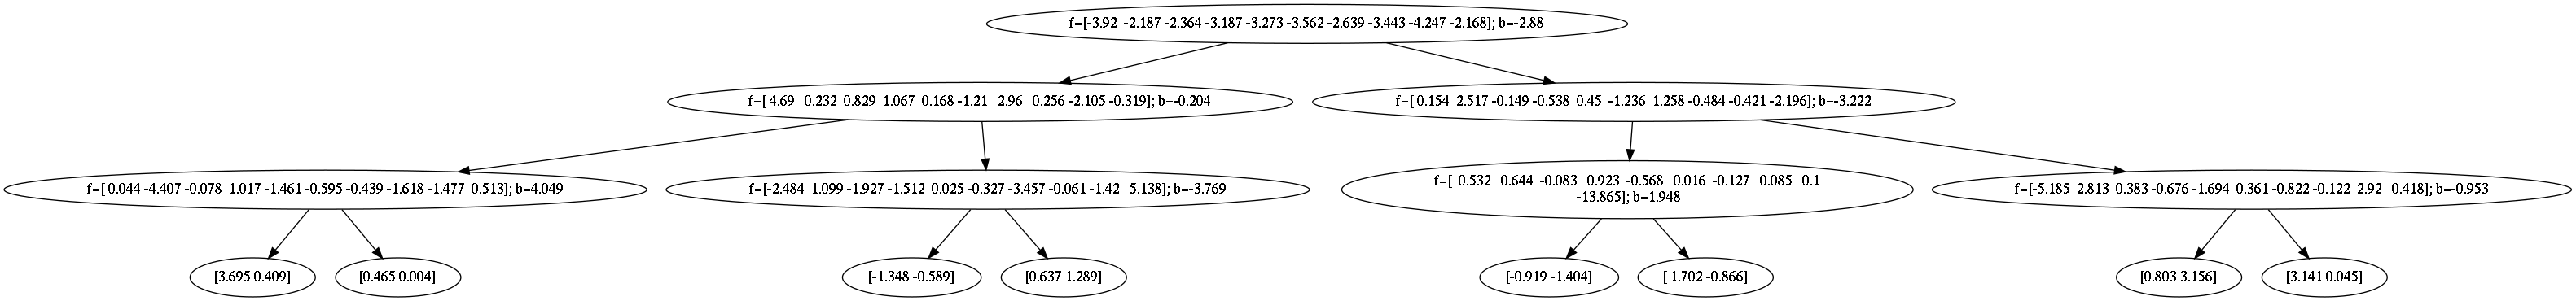

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(test_network_absenteeism_dt_inet, config=config, normalizer_list=normalizer_list)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(test_network_absenteeism_dt_inet, reshape=True, config=config)
    image = tree.plot_tree()
image

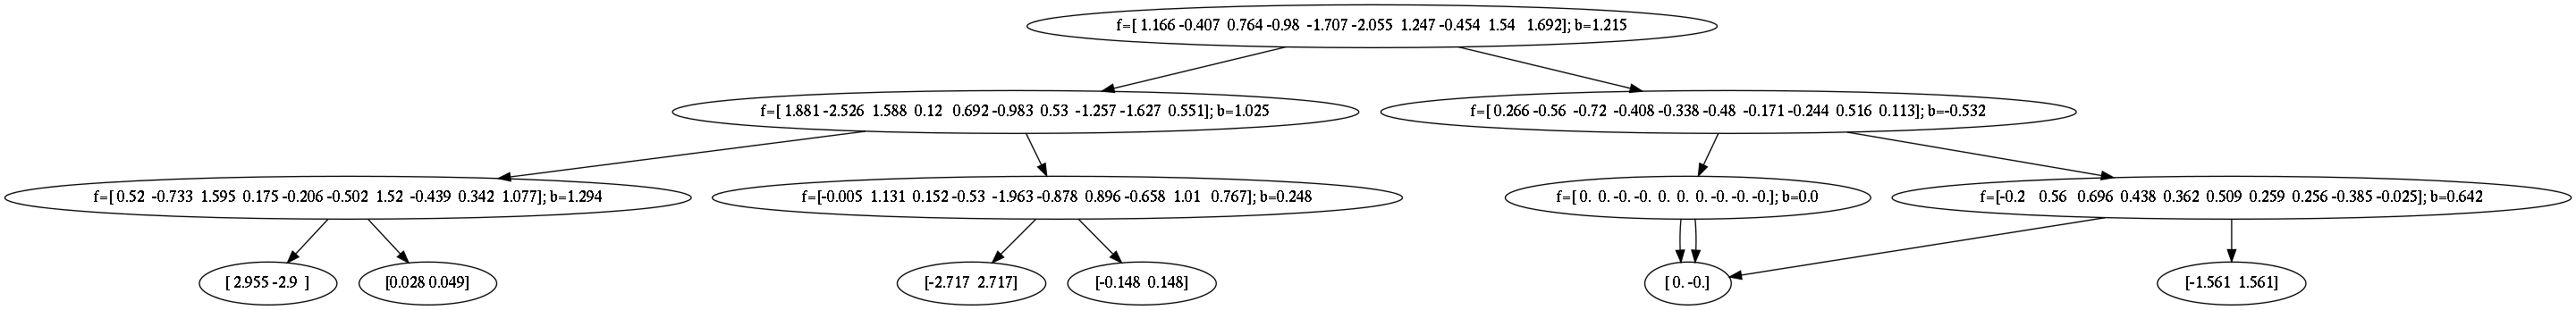

In [ ]:
if config['function_family']['dt_type'] == 'vanilla':
    plt.figure(figsize=(24,12))  # set plot size (denoted in inches)
    plot_tree(dt_distilled_absenteeism, fontsize=12)
    image = plt.show()
else:
    image = dt_distilled_absenteeism.plot_tree()
image

In [ ]:
if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
        if different_eval_data:
            flat_config = flatten_dict(config_train)
        else:
            flat_config = flatten_dict(config)
            
        for key in flat_config.keys():
            text_file.write(key + ';')
            
        text_file.write('dt_scores_binary_crossentropy_artificial_mean' + ';')
        text_file.write('dt_scores_accuracy_artificial_mean' + ';')
        text_file.write('dt_f1_score_artificial_mean' + ';')
        text_file.write('dt_scores_runtime_artificial_mean' + ';')
        text_file.write('inet_binary_crossentropy_artificial_mean' + ';')
        text_file.write('inet_accuracy_artificial_mean' + ';')
        text_file.write('inet_score_artificial_mean' + ';')
        text_file.write('inet_runtime_artificial_mean' + ';')
        
        
        for dataset_size in dataset_size_list_adult:
            text_file.write('dt_scores_data_random_binary_crossentropy_adult_' + str(dataset_size) + ';')
            text_file.write('dt_scores_binary_crossentropy_adult_' + str(dataset_size) + ';')
            text_file.write('dt_scores_data_random_accuracy_adult_' + str(dataset_size) + ';')
            text_file.write('dt_scores_accuracy_adult_' + str(dataset_size) + ';')
            text_file.write('dt_f1_score_data_random_adult_' + str(dataset_size) + ';')
            text_file.write('dt_f1_score_adult_' + str(dataset_size) + ';')
            text_file.write('dt_scores_runtime_adult_' + str(dataset_size) + ';')
            text_file.write('inet_binary_crossentropy_adult_' + str(dataset_size) + ';')
            text_file.write('inet_accuracy_adult_' + str(dataset_size) + ';')
            text_file.write('inet_score_adult_' + str(dataset_size) + ';')
            text_file.write('inet_runtime_adult_' + str(dataset_size) + ';')
        
        for dataset_size in dataset_size_list_titanic:
            text_file.write('dt_scores_data_random_binary_crossentropy_titanic_' + str(dataset_size) + ';')
            text_file.write('dt_scores_binary_crossentropy_titanic_' + str(dataset_size) + ';')
            text_file.write('dt_scores_data_random_accuracy_titanic_' + str(dataset_size) + ';')
            text_file.write('dt_scores_accuracy_titanic_' + str(dataset_size) + ';')
            text_file.write('dt_f1_score_data_random_titanic_' + str(dataset_size) + ';')
            text_file.write('dt_f1_score_titanic_' + str(dataset_size) + ';')
            text_file.write('dt_scores_runtime_titanic_' + str(dataset_size) + ';')
            text_file.write('inet_binary_crossentropy_titanic_' + str(dataset_size) + ';')
            text_file.write('inet_accuracy_titanic_' + str(dataset_size) + ';')
            text_file.write('inet_score_titanic_' + str(dataset_size) + ';')
            text_file.write('inet_runtime_titanic_' + str(dataset_size) + ';')
        
        for dataset_size in dataset_size_list_adult:
            text_file.write('dt_scores_data_random_binary_crossentropy_absenteeism_' + str(dataset_size) + ';')
            text_file.write('dt_scores_binary_crossentropy_absenteeism_' + str(dataset_size) + ';')
            text_file.write('dt_scores_data_random_accuracy_absenteeism_' + str(dataset_size) + ';')
            text_file.write('dt_scores_accuracy_absenteeism_' + str(dataset_size) + ';')
            text_file.write('dt_f1_score_data_random_absenteeism_' + str(dataset_size) + ';')
            text_file.write('dt_f1_score_absenteeism_' + str(dataset_size) + ';')
            text_file.write('dt_scores_runtime_absenteeism_' + str(dataset_size) + ';')
            text_file.write('inet_binary_crossentropy_absenteeism_' + str(dataset_size) + ';')
            text_file.write('inet_accuracy_absenteeism_' + str(dataset_size) + ';')
            text_file.write('inet_score_absenteeism_' + str(dataset_size) + ';')
            text_file.write('inet_runtime_absenteeism_' + str(dataset_size) + ';')        
    
        text_file.write('\n')
    
with open(writepath_summary, 'a+') as text_file: 
    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
        
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['binary_crossentropy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['accuracy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['f1_score']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['dt_scores']['runtime']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['binary_crossentropy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['accuracy']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['f1_score']) + ';')
    text_file.write(str(inet_evaluation_result_dict_mean['inet_scores']['runtime']) + ';')
    
    
    for i in range(len(dataset_size_list_adult)):
        text_file.write(str(adult_evaluation_result_dict['dt_scores']['binary_crossentropy_data_random'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['dt_scores']['binary_crossentropy'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['dt_scores']['accuracy_data_random'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['dt_scores']['accuracy'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['dt_scores']['f1_score_data_random'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['dt_scores']['f1_score'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['dt_scores']['runtime'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['inet_scores']['binary_crossentropy'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['inet_scores']['accuracy'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['inet_scores']['f1_score'][i]) + ';')
        text_file.write(str(adult_evaluation_result_dict['inet_scores']['runtime'][i]) + ';')
    
    for i in range(len(dataset_size_list_titanic)):
        text_file.write(str(titanic_evaluation_result_dict['dt_scores']['binary_crossentropy_data_random'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['dt_scores']['binary_crossentropy'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['dt_scores']['accuracy_data_random'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['dt_scores']['accuracy'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['dt_scores']['f1_score_data_random'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['dt_scores']['f1_score'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['dt_scores']['runtime'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['inet_scores']['binary_crossentropy'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['inet_scores']['accuracy'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['inet_scores']['f1_score'][i]) + ';')
        text_file.write(str(titanic_evaluation_result_dict['inet_scores']['runtime'][i]) + ';')
    
    for i in range(len(dataset_size_list_absenteeism)):
        text_file.write(str(absenteeism_evaluation_result_dict['dt_scores']['binary_crossentropy_data_random'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['dt_scores']['binary_crossentropy'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['dt_scores']['accuracy_data_random'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['dt_scores']['accuracy'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['dt_scores']['f1_score_data_random'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['dt_scores']['f1_score'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['dt_scores']['runtime'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['inet_scores']['binary_crossentropy'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['inet_scores']['accuracy'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['inet_scores']['f1_score'][i]) + ';')
        text_file.write(str(absenteeism_evaluation_result_dict['inet_scores']['runtime'][i]) + ';')
        
    text_file.write('\n')

    text_file.close()      

In [ ]:
#import gc
#gc.collect()

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

## NEXT DATASET

In [ ]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)

test_network = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

In [ ]:
test_network = generate_lambda_net_from_config(config, seed=RANDOM_SEED)

In [ ]:
test_network.get_weights()

[array([[-0.09073164, -0.0006602 ,  0.08985241, ...,  0.12817998,
          0.00403835, -0.00480796],
        [-0.08805869,  0.20603637,  0.19727673, ..., -0.12829414,
         -0.17797124,  0.19067724],
        [ 0.14257757, -0.01496924, -0.00960355, ..., -0.03049748,
          0.00118344,  0.08409108],
        ...,
        [ 0.00963099, -0.06634946, -0.0282515 , ...,  0.06962548,
         -0.07399707, -0.17853789],
        [ 0.20552249,  0.19661017,  0.20415898, ..., -0.14621095,
         -0.19687061,  0.2005982 ],
        [-0.16613625, -0.16404033,  0.10015564, ..., -0.17261569,
          0.09190981,  0.18089865]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
test_network.get_weights()

[array([[-0.09073164, -0.0006602 ,  0.08985241, ...,  0.12817998,
          0.00403835, -0.00480796],
        [-0.08805869,  0.20603637,  0.19727673, ..., -0.12829414,
         -0.17797124,  0.19067724],
        [ 0.14257757, -0.01496924, -0.00960355, ..., -0.03049748,
          0.00118344,  0.08409108],
        ...,
        [ 0.00963099, -0.06634946, -0.0282515 , ...,  0.06962548,
         -0.07399707, -0.17853789],
        [ 0.20552249,  0.19661017,  0.20415898, ..., -0.14621095,
         -0.19687061,  0.2005982 ],
        [-0.16613625, -0.16404033,  0.10015564, ..., -0.17261569,
          0.09190981,  0.18089865]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.